## **Data collection**

###**Importing Libraries**

In [ ]:
! conda install -c conda-forge py-xgboost-gpu

/bin/bash: line 1: conda: command not found


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statistics as state
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

### **Importing Dataset**

In [ ]:
data = pd.read_csv('/content/thyroid.csv')
data.head()

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,TT4measured,T4,T4Umeasured,T4U,FTImeasured,FTI,TBGmeasured,TBG,referral source,Result
0,12,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,P
1,20,M,f,f,f,f,f,f,f,f,...,t,102.0,f,0.00,f,0.0,f,NaN,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175.0,f,0.00,f,0.0,f,NaN,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,P


### **Exploratory Data Analysis**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 0 to 3769
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      3770 non-null   int64  
 1   sex                      3620 non-null   object 
 2   thyroxine                3770 non-null   object 
 3   queryonthyroxine         3770 non-null   object 
 4   onantithyroidmedication  3770 non-null   object 
 5   sick                     3770 non-null   object 
 6   pregnant                 3770 non-null   object 
 7   thyroidsurgery           3770 non-null   object 
 8   I131treatment            3770 non-null   object 
 9   queryhypothyroid         3770 non-null   object 
 10  queryhyperthyroid        3770 non-null   object 
 11  lithium                  3770 non-null   object 
 12  goitre                   3770 non-null   object 
 13  tumor                    3770 non-null   object 
 14  hypopituitary           

In [ ]:
# shape of the dataset
data.shape

(3770, 30)

In [ ]:
# size of the dataset
data.size

113100

In [ ]:
# Viewing the dataset Columns
data.describe()

,Age,TSH,T3,T4,T4U,FTI,TBG
count,3770.000000,3770.000000,3770.000000,3770.000000,3770.000000,3770.000000,0.0
mean,51.724934,4.591025,1.603008,101.678462,0.892921,99.176844,NaN
std,20.097915,23.345886,1.097207,43.192637,0.354295,45.851205,NaN
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,36.000000,0.200000,0.900000,84.000000,0.840000,86.250000,NaN
50%,54.000000,1.200000,1.800000,102.000000,0.950000,104.000000,NaN
75%,67.000000,2.475000,2.200000,123.000000,1.070000,121.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


In [ ]:
# Checking for the data types
data.dtypes

Age                          int64
sex                         object
thyroxine                   object
queryonthyroxine            object
onantithyroidmedication     object
sick                        object
pregnant                    object
thyroidsurgery              object
I131treatment               object
queryhypothyroid            object
queryhyperthyroid           object
lithium                     object
goitre                      object
tumor                       object
hypopituitary               object
psych                       object
TSHmeasured                 object
TSH                        float64
T3measured                  object
T3                         float64
TT4measured                 object
T4                         float64
T4Umeasured                 object
T4U                        float64
FTImeasured                 object
FTI                        float64
TBGmeasured                 object
TBG                        float64
referral source     

In [ ]:
data.columns

Index(['Age', 'sex', 'thyroxine', 'queryonthyroxine',
       'onantithyroidmedication', 'sick', 'pregnant', 'thyroidsurgery',
       'I131treatment', 'queryhypothyroid', 'queryhyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSHmeasured', 'TSH',
       'T3measured', 'T3', 'TT4measured', 'T4', 'T4Umeasured', 'T4U',
       'FTImeasured', 'FTI', 'TBGmeasured', 'TBG', 'referral source',
       'Result'],
      dtype='object')

### **Feature Engineering**

In [ ]:
data['Result'].unique()

array(['P', 'N'], dtype=object)

In [ ]:
data['Result'].value_counts()

Result
P    3479
N     291
Name: count, dtype: int64

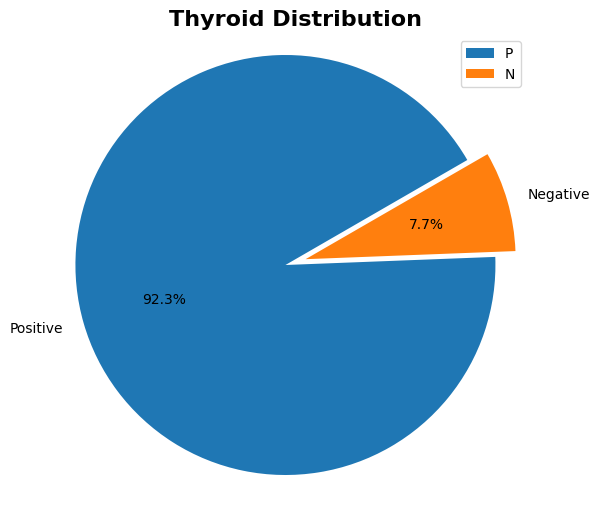

In [ ]:
import matplotlib.pyplot as plt

def balanced_plot(data):
    positive_count = data['Result'].value_counts()['P']
    negative_count = data['Result'].value_counts()['N']
    labels = ['Positive', 'Negative']
    sizes = [positive_count, negative_count]
    colors = ['#1f77b4', '#ff7f0e']  # Blue for Positive, Orange for Negative
    explode = (0.1, 0)  # explode the 1st slice (Positive)

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=30)
    plt.axis('equal')
    plt.title('Thyroid Distribution', fontsize=16, fontweight='bold')
    plt.legend(data['Result'].value_counts().index, loc='best')
    plt.show()

balanced_plot(data)

In [ ]:
# Create an empty list to store unique values
unique_values_list = []

# Iterate through each column in the dataset
for col in data.columns:
    # Get unique values for the current column
    unique_values = pd.unique(data[col])

    # Append the column name and its unique values to the list
    unique_values_list.append({'Column Name': col, 'Unique Values': unique_values})

# Create a DataFrame from the list of dictionaries
unique_values_df = pd.DataFrame(unique_values_list)

# Display the DataFrame
unique_values_df

,Column Name,Unique Values
0,Age,"[12, 20, 46, 70, 18, 59, 80, 66, 68, 84, 67, 7..."
1,sex,"[F, M, nan]"
2,thyroxine,"[f, t]"
3,queryonthyroxine,"[f, t]"
4,onantithyroidmedication,"[f, t]"
5,sick,"[f, t]"
6,pregnant,"[f, t]"
7,thyroidsurgery,"[f, t]"
8,I131treatment,"[f, t]"
9,queryhypothyroid,"[f, t]"


## **Data Preprocessing**

### **Check Missing Values**

In [ ]:
data.isnull().sum()

,0
Age,0
sex,150
thyroxine,0
queryonthyroxine,0
onantithyroidmedication,0
sick,0
pregnant,0
thyroidsurgery,0
I131treatment,0
queryhypothyroid,0


In [ ]:
# Let's drop some unnecessary columns
data=data.drop(['TSHmeasured','T3measured', 'TT4measured',  'T4Umeasured','FTImeasured','TBG','TBGmeasured'],axis=1)
#Dropping faulty data
data=data[data['Age']!=455]

In [ ]:
data

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,tumor,hypopituitary,psych,TSH,T3,T4,T4U,FTI,referral source,Result
0,12,F,f,f,f,f,f,f,f,f,...,f,f,f,1.30,2.5,125.0,1.14,109.0,SVHC,P
1,20,M,f,f,f,f,f,f,f,f,...,f,f,f,4.10,2.0,102.0,0.00,0.0,other,P
2,46,M,f,f,f,f,f,f,f,f,...,f,f,f,0.98,0.0,109.0,0.91,120.0,other,P
3,70,F,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175.0,0.00,0.0,other,P
4,70,F,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61.0,0.87,70.0,SVI,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,30,F,f,f,f,f,f,f,f,f,...,t,f,f,0.00,0.0,0.0,0.00,0.0,other,P
3766,68,F,f,f,f,f,f,f,f,f,...,f,f,f,1.00,2.1,124.0,1.08,114.0,SVI,P
3767,74,F,f,f,f,f,f,f,f,f,...,f,f,f,5.10,1.8,112.0,1.07,105.0,other,P
3768,72,M,f,f,f,f,f,f,f,f,...,f,f,f,0.70,2.0,82.0,0.94,87.0,SVI,P


### **Imputation method for categorical columns**

In [ ]:
most_frequent_sex = data['sex'].mode()[0]
data['sex'].fillna(most_frequent_sex, inplace=True)

<ipython-input-6-3990da54c4fd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sex'].fillna(most_frequent_sex, inplace=True)


In [ ]:
data.isnull().sum()

,0
Age,0
sex,0
thyroxine,0
queryonthyroxine,0
onantithyroidmedication,0
sick,0
pregnant,0
thyroidsurgery,0
I131treatment,0
queryhypothyroid,0


### **Duplicates**

In [ ]:
# dropping duplicates
data.duplicated().sum()

63

In [ ]:
data = data.drop_duplicates(keep=False)

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.shape

(3672, 23)

### **Scaling (Normalization)**

In [ ]:
from sklearn.preprocessing import LabelEncoder
lblEn=LabelEncoder()
columns=data.select_dtypes(include=['object']).columns
for i in columns:
  data[i]=lblEn.fit_transform(data[i])

In [ ]:
data.head()

,Age,sex,thyroxine,queryonthyroxine,onantithyroidmedication,sick,pregnant,thyroidsurgery,I131treatment,queryhypothyroid,...,tumor,hypopituitary,psych,TSH,T3,T4,T4U,FTI,referral source,Result
0,12,0,0,0,0,0,0,0,0,0,...,0,0,0,1.30,2.5,125.0,1.14,109.0,1,1
1,20,1,0,0,0,0,0,0,0,0,...,0,0,0,4.10,2.0,102.0,0.00,0.0,4,1
2,46,1,0,0,0,0,0,0,0,0,...,0,0,0,0.98,0.0,109.0,0.91,120.0,4,1
3,70,0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175.0,0.00,0.0,4,1
4,70,0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61.0,0.87,70.0,3,1


In [ ]:
data['Result'].value_counts()

,count
Result,
1,3381
0,291


<ipython-input-15-4e06a9895db3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Result', palette='Set2')


<Axes: xlabel='Result', ylabel='count'>

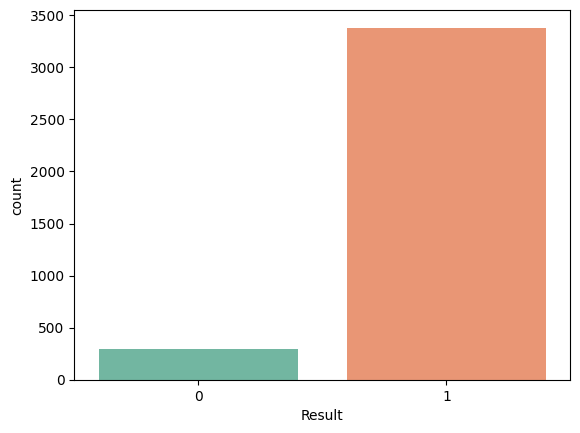

In [ ]:
sns.countplot(data=data, x='Result', palette='Set2')

## **Split the dataset**

In [ ]:
x=data.drop(['Result'],axis=1) #x contains all the features
y=data.Result   #y contains class label

In [ ]:
x.shape

(3672, 22)

In [ ]:
y.shape

(3672,)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape

(2937, 22)

In [ ]:
y_train.shape

(2937,)

In [ ]:
x_test.shape

(735, 22)

In [ ]:
y_test.shape

(735,)

## **Hybrid Ensemble**

In [ ]:
# Initialize a StratifiedKFold for 5 splits/folds
skf = StratifiedKFold(n_splits=5,
                      random_state=1,
                      shuffle=True)

### **NB**

In [ ]:
# Initialize the NB model
# nb_model = GaussianNB()
# nb_model = BernoulliNB()
nb_model= MultinomialNB()

Fold 1 Accuracy: 92.93%
Fold 2 Accuracy: 92.38%
Fold 3 Accuracy: 90.74%
Fold 4 Accuracy: 91.01%
Fold 5 Accuracy: 93.19%

Average Accuracy: 92.05%

Fold 1:


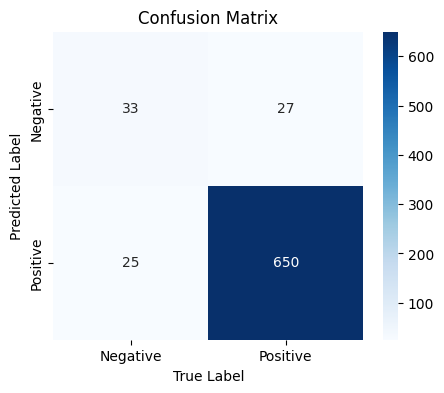


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        58
           1       0.96      0.96      0.96       677

    accuracy                           0.93       735
   macro avg       0.76      0.76      0.76       735
weighted avg       0.93      0.93      0.93       735


Fold 2:


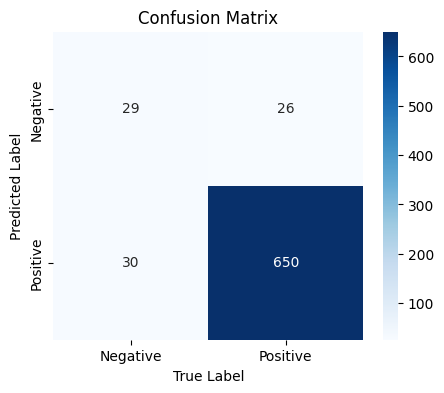


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51        59
           1       0.96      0.96      0.96       676

    accuracy                           0.92       735
   macro avg       0.74      0.73      0.73       735
weighted avg       0.92      0.92      0.92       735


Fold 3:


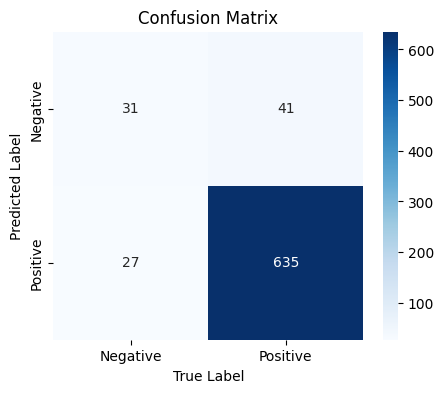


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.53      0.48        58
           1       0.96      0.94      0.95       676

    accuracy                           0.91       734
   macro avg       0.69      0.74      0.71       734
weighted avg       0.92      0.91      0.91       734


Fold 4:


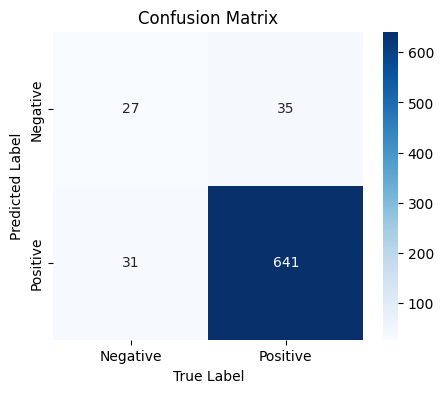


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.47      0.45        58
           1       0.95      0.95      0.95       676

    accuracy                           0.91       734
   macro avg       0.69      0.71      0.70       734
weighted avg       0.91      0.91      0.91       734


Fold 5:


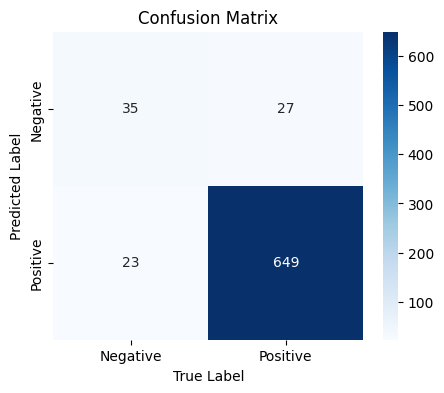


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        58
           1       0.97      0.96      0.96       676

    accuracy                           0.93       734
   macro avg       0.77      0.78      0.77       734
weighted avg       0.93      0.93      0.93       734



In [ ]:
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    nb_model.fit(x_train, y_train)

    # Predict on the test set
    y_pred = nb_model.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')

### **DT**

In [ ]:
# setup parameter space
parameters = {'criterion':['gini','entropy'],
              'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

# create an instance of the grid search object
g1 = RandomizedSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)
g1.fit(x,y)
# show best parameter configuration found for classifier
cls_params1 = g1.best_params_
cls_params1

{'min_samples_split': 2,
 'max_leaf_nodes': 7,
 'max_depth': 7,
 'criterion': 'gini'}

In [ ]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(criterion= 'gini',
                               min_samples_split=2,
                               max_leaf_nodes=7,
                               max_depth= 7)

In [ ]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(criterion= 'entropy',
                               min_samples_split=8,
                               max_leaf_nodes=7,
                               max_depth= 17)

Fold 1 Accuracy: 99.73%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 99.46%
Fold 4 Accuracy: 99.59%
Fold 5 Accuracy: 99.59%

Average Accuracy: 99.67%

Fold 1:


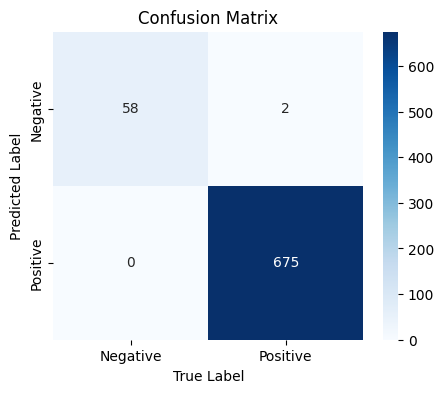


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       1.00      1.00      1.00       677

    accuracy                           1.00       735
   macro avg       0.98      1.00      0.99       735
weighted avg       1.00      1.00      1.00       735


Fold 2:


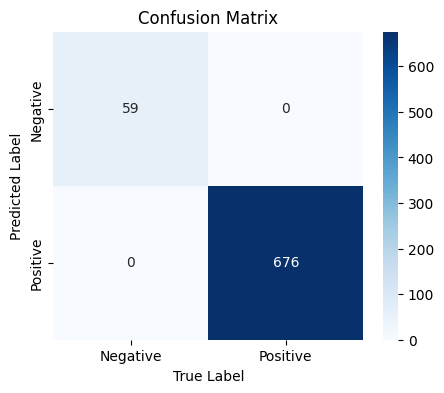


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       676

    accuracy                           1.00       735
   macro avg       1.00      1.00      1.00       735
weighted avg       1.00      1.00      1.00       735


Fold 3:


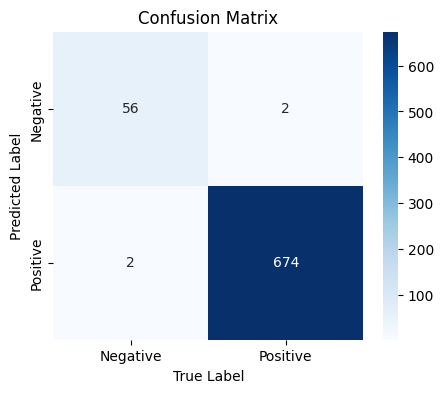


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        58
           1       1.00      1.00      1.00       676

    accuracy                           0.99       734
   macro avg       0.98      0.98      0.98       734
weighted avg       0.99      0.99      0.99       734


Fold 4:


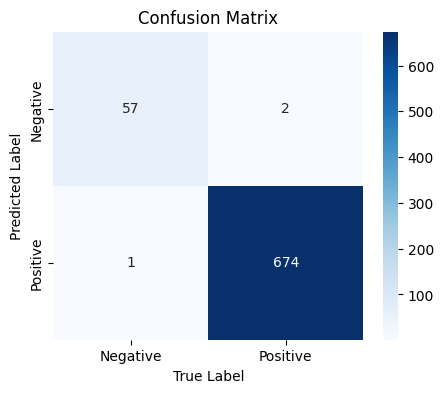


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       1.00      1.00      1.00       676

    accuracy                           1.00       734
   macro avg       0.98      0.99      0.99       734
weighted avg       1.00      1.00      1.00       734


Fold 5:


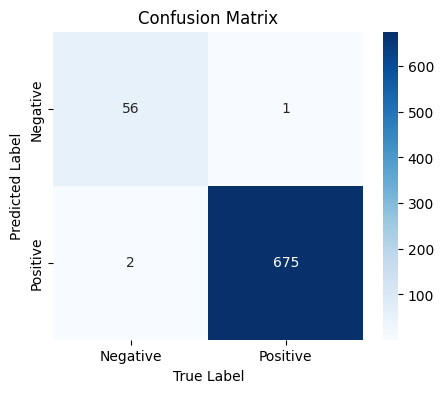


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       1.00      1.00      1.00       676

    accuracy                           1.00       734
   macro avg       0.99      0.98      0.99       734
weighted avg       1.00      1.00      1.00       734



In [ ]:
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    dt_model.fit(x_train, y_train)

    # Predict on the test set
    y_pred = dt_model.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')

### **KNN**

In [ ]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(metric='minkowski',p=2,n_neighbors=5,algorithm='auto',weights='distance')

Fold 1 Accuracy: 95.78%
Fold 2 Accuracy: 95.10%
Fold 3 Accuracy: 94.41%
Fold 4 Accuracy: 94.82%
Fold 5 Accuracy: 96.32%

Average Accuracy: 95.29%

Fold 1:


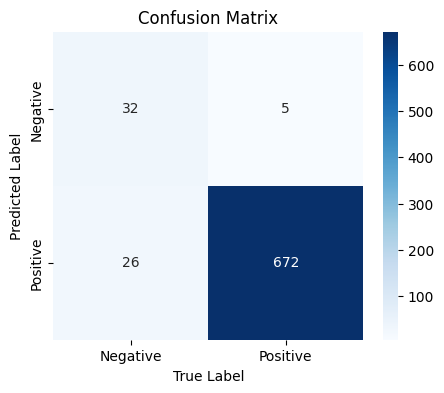


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        58
           1       0.96      0.99      0.98       677

    accuracy                           0.96       735
   macro avg       0.91      0.77      0.83       735
weighted avg       0.96      0.96      0.95       735


Fold 2:


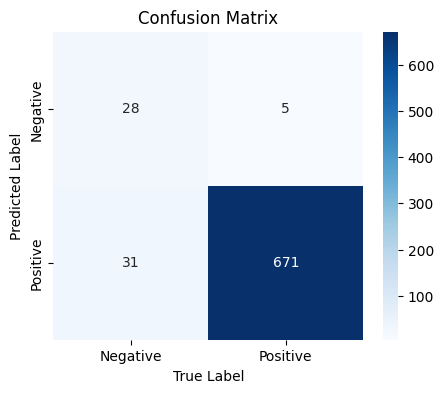


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.47      0.61        59
           1       0.96      0.99      0.97       676

    accuracy                           0.95       735
   macro avg       0.90      0.73      0.79       735
weighted avg       0.95      0.95      0.94       735


Fold 3:


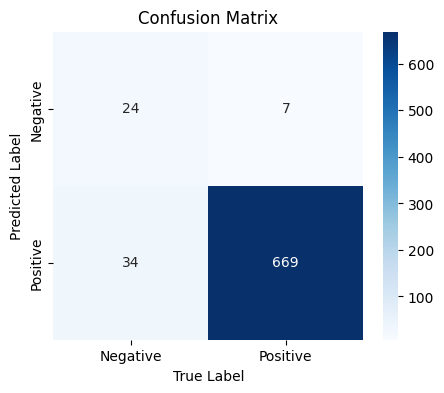


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.41      0.54        58
           1       0.95      0.99      0.97       676

    accuracy                           0.94       734
   macro avg       0.86      0.70      0.75       734
weighted avg       0.94      0.94      0.94       734


Fold 4:


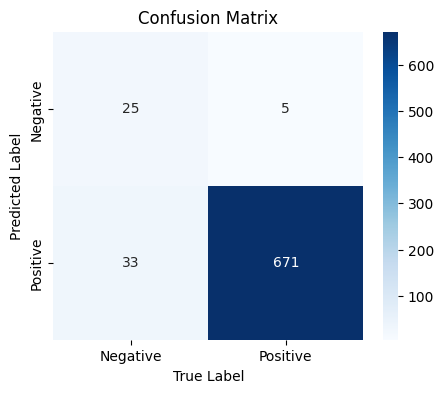


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.43      0.57        58
           1       0.95      0.99      0.97       676

    accuracy                           0.95       734
   macro avg       0.89      0.71      0.77       734
weighted avg       0.94      0.95      0.94       734


Fold 5:


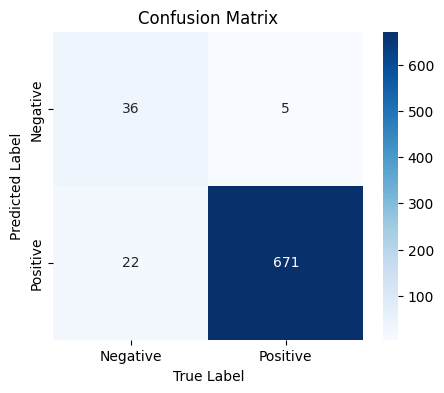


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73        58
           1       0.97      0.99      0.98       676

    accuracy                           0.96       734
   macro avg       0.92      0.81      0.85       734
weighted avg       0.96      0.96      0.96       734



In [ ]:
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    knn_model.fit(x_train, y_train)

    # Predict on the test set
    y_pred = knn_model.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')

### **SVM**

In [ ]:
# setup parameter space
parameters = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [2, 3, 5], 'gamma': ['scale']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale']},
    {'C': [0.1, 1, 10], 'kernel': ['sigmoid'], 'gamma': ['scale']}
]

# create an instance of the grid search object
g1 = RandomizedSearchCV(SVC(), parameters, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
g1.fit(x,y)

# show best parameter configuration found for classifier
cls_params1 = g1.best_params_
cls_params1

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'kernel': 'linear', 'C': 10}

In [ ]:
# Initialize the SVM classifier with linear kernel
svm_model = SVC(kernel='linear', C=10, probability=True)

Fold 1 Accuracy: 97.28%
Fold 2 Accuracy: 97.41%
Fold 3 Accuracy: 96.73%
Fold 4 Accuracy: 96.87%
Fold 5 Accuracy: 98.23%

Average Accuracy: 97.30%

Fold 1:


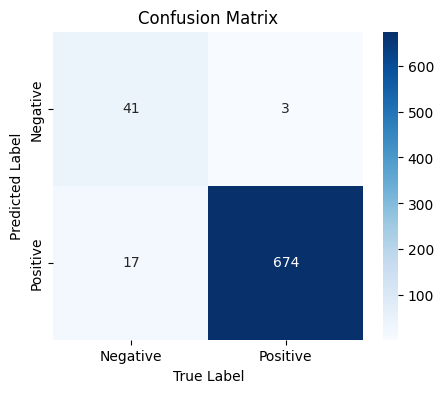


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80        58
           1       0.98      1.00      0.99       677

    accuracy                           0.97       735
   macro avg       0.95      0.85      0.89       735
weighted avg       0.97      0.97      0.97       735


Fold 2:


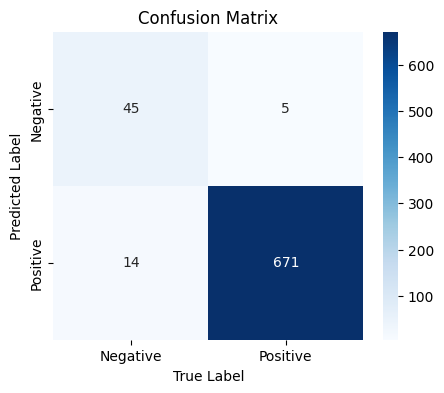


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        59
           1       0.98      0.99      0.99       676

    accuracy                           0.97       735
   macro avg       0.94      0.88      0.91       735
weighted avg       0.97      0.97      0.97       735


Fold 3:


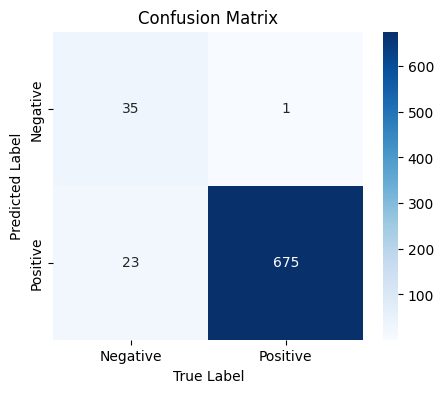


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74        58
           1       0.97      1.00      0.98       676

    accuracy                           0.97       734
   macro avg       0.97      0.80      0.86       734
weighted avg       0.97      0.97      0.96       734


Fold 4:


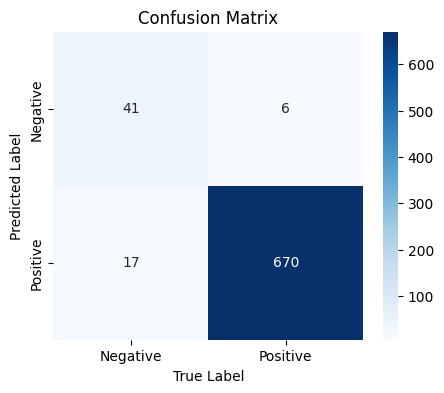


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        58
           1       0.98      0.99      0.98       676

    accuracy                           0.97       734
   macro avg       0.92      0.85      0.88       734
weighted avg       0.97      0.97      0.97       734


Fold 5:


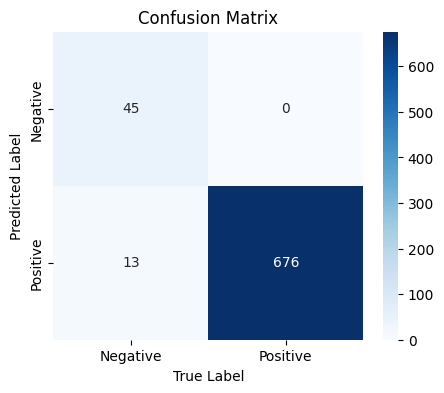


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87        58
           1       0.98      1.00      0.99       676

    accuracy                           0.98       734
   macro avg       0.99      0.89      0.93       734
weighted avg       0.98      0.98      0.98       734



In [ ]:
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    svm_model.fit(x_train, y_train)

    # Predict on the test set
    y_pred = svm_model.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')

### **Voting**

Fold 1 Accuracy: 95.65%
Fold 2 Accuracy: 95.10%
Fold 3 Accuracy: 95.37%
Fold 4 Accuracy: 95.10%
Fold 5 Accuracy: 96.59%

Average Accuracy: 95.56%

Fold 1:


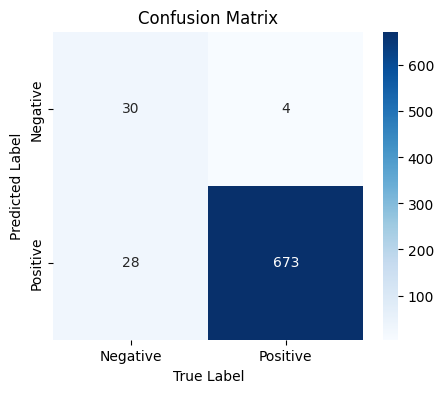


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.52      0.65        58
           1       0.96      0.99      0.98       677

    accuracy                           0.96       735
   macro avg       0.92      0.76      0.81       735
weighted avg       0.95      0.96      0.95       735


Fold 2:


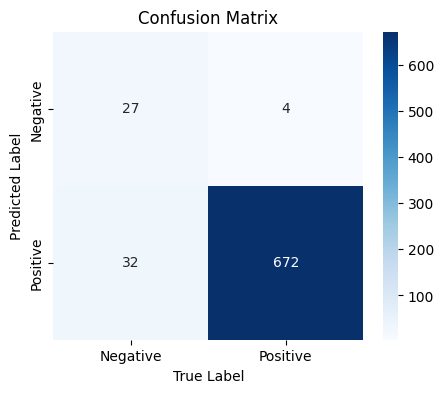


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.46      0.60        59
           1       0.95      0.99      0.97       676

    accuracy                           0.95       735
   macro avg       0.91      0.73      0.79       735
weighted avg       0.95      0.95      0.94       735


Fold 3:


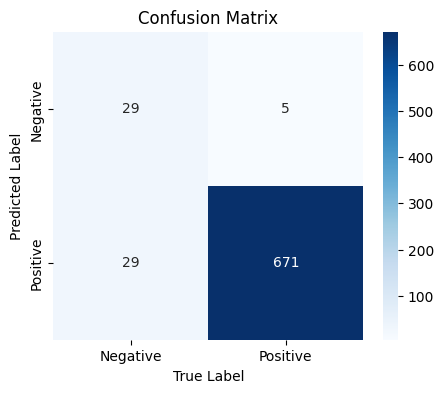


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63        58
           1       0.96      0.99      0.98       676

    accuracy                           0.95       734
   macro avg       0.91      0.75      0.80       734
weighted avg       0.95      0.95      0.95       734


Fold 4:


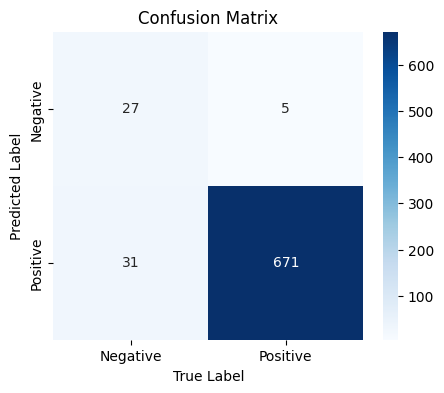


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.47      0.60        58
           1       0.96      0.99      0.97       676

    accuracy                           0.95       734
   macro avg       0.90      0.73      0.79       734
weighted avg       0.95      0.95      0.94       734


Fold 5:


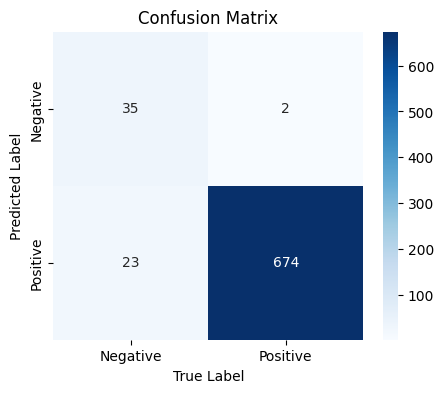


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74        58
           1       0.97      1.00      0.98       676

    accuracy                           0.97       734
   macro avg       0.96      0.80      0.86       734
weighted avg       0.97      0.97      0.96       734



In [ ]:
# Define the classifiers list
classifiers = [('nb', nb_model), ('knn', knn_model), ('svm', svm_model)]
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []
# Placeholder for predicted probabilities
y_probabilities = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a voting classifier.
    voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

    # Train the voting classifier.
    voting_clf.fit(x_train, y_train)

    # Make predictions.
    y_pred = voting_clf.predict(x_test)
    y_proba = voting_clf.predict_proba(x_test)  # Get class probabilities
    y_probabilities.append(y_proba)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')


Fold 1 Accuracy: 95.78%
Fold 2 Accuracy: 95.92%
Fold 3 Accuracy: 95.78%
Fold 4 Accuracy: 95.50%
Fold 5 Accuracy: 96.87%

Average Accuracy: 95.97%

Fold 1:


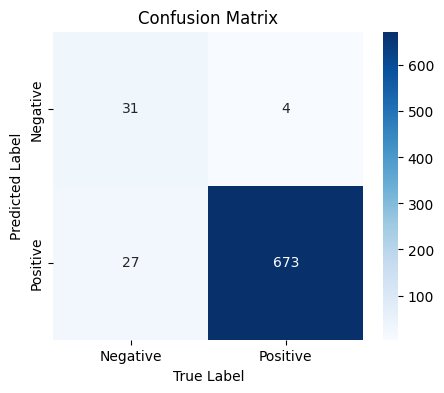


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.53      0.67        58
           1       0.96      0.99      0.98       677

    accuracy                           0.96       735
   macro avg       0.92      0.76      0.82       735
weighted avg       0.96      0.96      0.95       735


Fold 2:


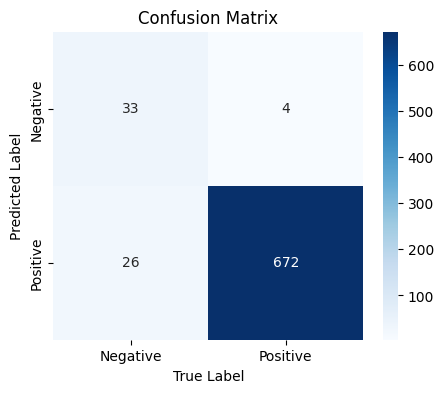


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69        59
           1       0.96      0.99      0.98       676

    accuracy                           0.96       735
   macro avg       0.93      0.78      0.83       735
weighted avg       0.96      0.96      0.95       735


Fold 3:


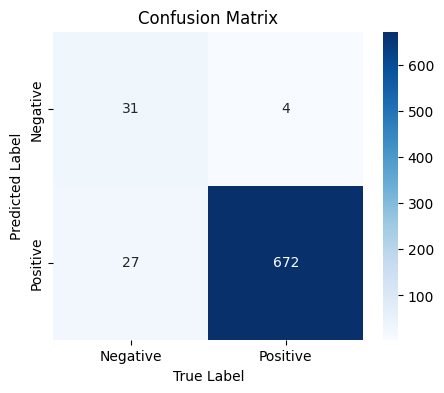


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.53      0.67        58
           1       0.96      0.99      0.98       676

    accuracy                           0.96       734
   macro avg       0.92      0.76      0.82       734
weighted avg       0.96      0.96      0.95       734


Fold 4:


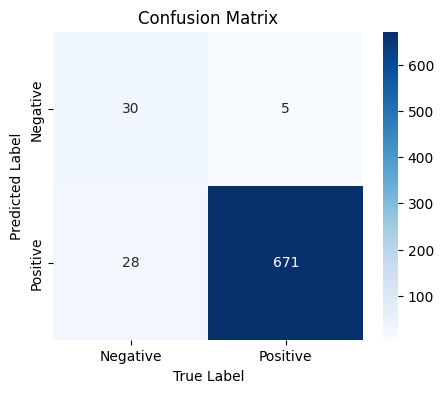


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.52      0.65        58
           1       0.96      0.99      0.98       676

    accuracy                           0.96       734
   macro avg       0.91      0.75      0.81       734
weighted avg       0.95      0.96      0.95       734


Fold 5:


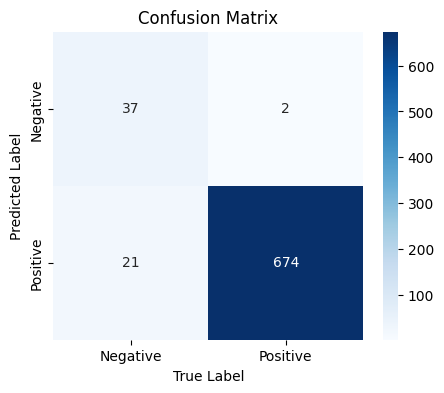


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76        58
           1       0.97      1.00      0.98       676

    accuracy                           0.97       734
   macro avg       0.96      0.82      0.87       734
weighted avg       0.97      0.97      0.97       734



In [ ]:
# Define the classifiers list
classifiers = [('nb', nb_model), ('knn', knn_model), ('svm', svm_model)]
# Placeholder for model accuracy scores
accuracy_scores = []
# Placeholder for model metrics
conf_matrices = []
classification_reports = []
# Placeholder for predicted probabilities
y_probabilities = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a voting classifier.
    voting_clf = VotingClassifier(estimators=classifiers, voting='hard')

    # Train the voting classifier.
    voting_clf.fit(x_train, y_train)

    # Make predictions.
    y_pred = voting_clf.predict(x_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')


## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

x_smote, y_smote = smote.fit_resample(x_train, y_train)

In [ ]:
print("Shape before the Oversampling : ",x_train.shape)
print("Shape after the Oversampling : ",x_smote.shape)

Shape before the Oversampling :  (2937, 22)
Shape after the Oversampling :  (5402, 22)


In [ ]:
print("Shape before the Oversampling : ",y_train.shape)
print("Shape after the Oversampling : ",y_smote.shape)

Shape before the Oversampling :  (2937,)
Shape after the Oversampling :  (5402,)


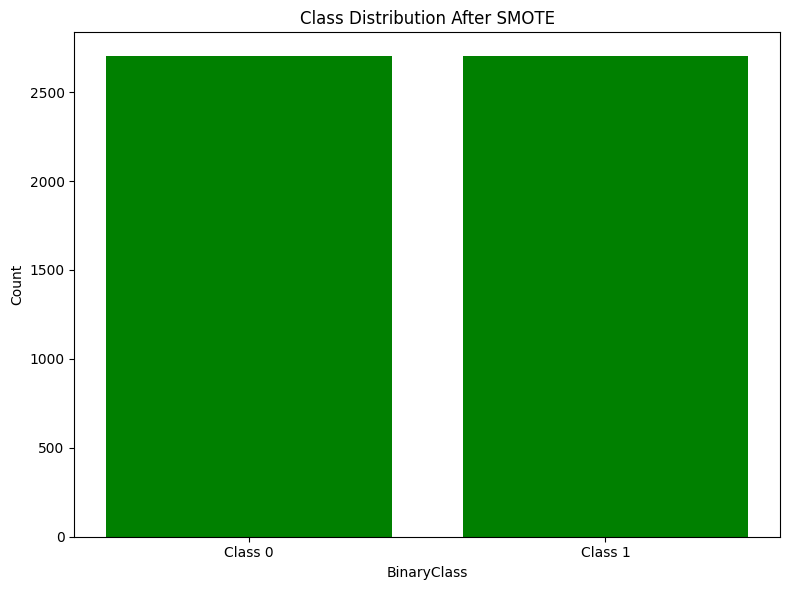

In [ ]:
# Calculate class distribution after SMOTE
unique, counts = np.unique(y_smote, return_counts=True)
counts_after = dict(zip(unique, counts))

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(counts_after.keys(), counts_after.values(), color='g')
plt.xticks(list(counts_after.keys()), ['Class 0', 'Class 1'])  # Replace with actual class labels if needed
plt.title('Class Distribution After SMOTE')
plt.xlabel('BinaryClass')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:
{'kernel': 'linear', 'C': 10}

Accuracy : 98.37%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        55
           1       0.99      0.99      0.99       680

    accuracy                           0.98       735
   macro avg       0.93      0.96      0.94       735
weighted avg       0.98      0.98      0.98       735



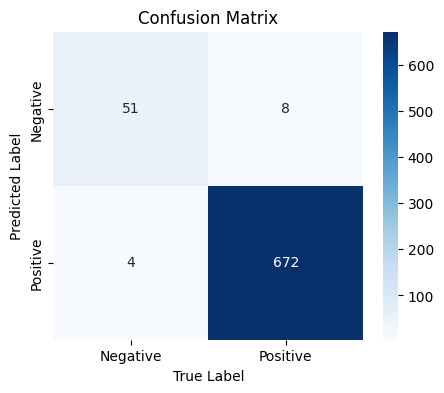

In [ ]:
# Define parameter grid for tuning
parameters = [
    {'C': [0.1, 1, 10], 'kernel': ['linear']},
    {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [2, 3, 5], 'gamma': ['scale']},
    {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale']},
    {'C': [0.1, 1, 10], 'kernel': ['sigmoid'], 'gamma': ['scale']}
]

# Perform Randomized Search CV for parameter tuning
g2_search = RandomizedSearchCV(SVC(), parameters, cv=5, n_jobs=-1)
g2_search.fit(x_smote, y_smote)

# Get the best model and its parameters
best_svm_model = g2_search.best_estimator_
best_params = g2_search.best_params_

print("Best parameters found:")
print(best_params)
print()

# Evaluate the best model on test data
y_pred = best_svm_model.predict(x_test)

# Calculate accuracy
accuracy = best_svm_model.score(x_test, y_test) * 100
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}%")
# Print classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## **Ensembling Using XGBoosting**

In [ ]:
# Create matrices
dtrain = xgb.DMatrix(x_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(x_test, y_test, enable_categorical=True)

In [ ]:
# Define hyperparameters
e_params = {"objective": "reg:squarederror", "tree_method": "hist", "device" : "cuda" }

#Evaluation paprameters
evals = [(dtrain, "train"), (dtest, "validation")]

# Number of boosts
n = 20

# Placeholder for best iterations
best_iterations = []

# Initialize a StratifiedKFold for 5 splits/folds
skf = StratifiedKFold(n_splits=5,
                      random_state=1,
                      shuffle=True)
# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create matrices
    dtrain = xgb.DMatrix(x_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(x_test, y_test, enable_categorical=True)

    # Train the model
    e_model = xgb.train(
      params=e_params,
      dtrain=dtrain,
      num_boost_round=n,
      evals=evals,
      verbose_eval=3,
      early_stopping_rounds=2
    )

    # Get the best iteration
    best_iteration=e_model.best_iteration
    best_iterations.append(best_iteration)
    print(f'\nBest Iteration for Fold {i}: {best_iteration}\n')
print(len(best_iterations))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:01] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.19233	validation-rmse:0.19095
[3]	train-rmse:0.07562	validation-rmse:0.06932
[6]	train-rmse:0.03960	validation-rmse:0.02669
[9]	train-rmse:0.03056	validation-rmse:0.01231
[12]	train-rmse:0.02651	validation-rmse:0.00812
[15]	train-rmse:0.02502	validation-rmse:0.00482
[18]	train-rmse:0.02477	validation-rmse:0.00276
[19]	train-rmse:0.02463	validation-rmse:0.00239

Best Iteration for Fold 1: 19



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:02] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.19213	validation-rmse:0.19106
[3]	train-rmse:0.07360	validation-rmse:0.06905
[6]	train-rmse:0.03805	validation-rmse:0.02605
[9]	train-rmse:0.03113	validation-rmse:0.01239
[12]	train-rmse:0.02878	validation-rmse:0.00805
[15]	train-rmse:0.02712	validation-rmse:0.00514
[18]	train-rmse:0.02632	validation-rmse:0.00301
[19]	train-rmse:0.02630	validation-rmse:0.00262

Best Iteration for Fold 2: 19

[0]	train-rmse:0.19364	validation-rmse:0.19135


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:03] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	train-rmse:0.08110	validation-rmse:0.06910
[6]	train-rmse:0.05025	validation-rmse:0.02582
[9]	train-rmse:0.04355	validation-rmse:0.01085
[12]	train-rmse:0.04201	validation-rmse:0.00613
[15]	train-rmse:0.04137	validation-rmse:0.00375
[18]	train-rmse:0.04127	validation-rmse:0.00260
[19]	train-rmse:0.04125	validation-rmse:0.00219

Best Iteration for Fold 3: 19

[0]	train-rmse:0.19340	validation-rmse:0.19092
[3]	train-rmse:0.08290	validation-rmse:0.06885
[6]	train-rmse:0.05467	validation-rmse:0.02602
[9]	train-rmse:0.04975	validation-rmse:0.01102
[12]	train-rmse:0.04903	validation-rmse:0.00661


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:04] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	train-rmse:0.04885	validation-rmse:0.00406
[18]	train-rmse:0.04880	validation-rmse:0.00246
[19]	train-rmse:0.04883	validation-rmse:0.00203

Best Iteration for Fold 4: 19

[0]	train-rmse:0.19246	validation-rmse:0.19455
[3]	train-rmse:0.07450	validation-rmse:0.09257
[6]	train-rmse:0.03774	validation-rmse:0.07439


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:04] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	train-rmse:0.02146	validation-rmse:0.07328

Best Iteration for Fold 5: 8

5


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Fold 1 Accuracy: 99.73%
Fold 2 Accuracy: 99.73%
Fold 3 Accuracy: 99.46%
Fold 4 Accuracy: 98.91%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Fold 5 Accuracy: 99.46%

Average Accuracy: 99.46%

Fold 1:


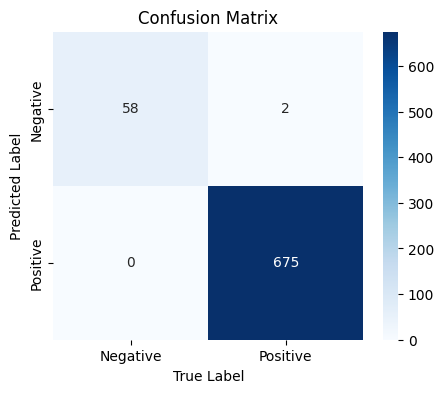


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       1.00      1.00      1.00       677

    accuracy                           1.00       735
   macro avg       0.98      1.00      0.99       735
weighted avg       1.00      1.00      1.00       735


Fold 2:


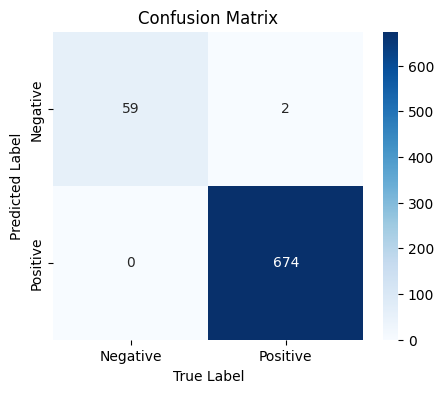


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       1.00      1.00      1.00       676

    accuracy                           1.00       735
   macro avg       0.98      1.00      0.99       735
weighted avg       1.00      1.00      1.00       735


Fold 3:


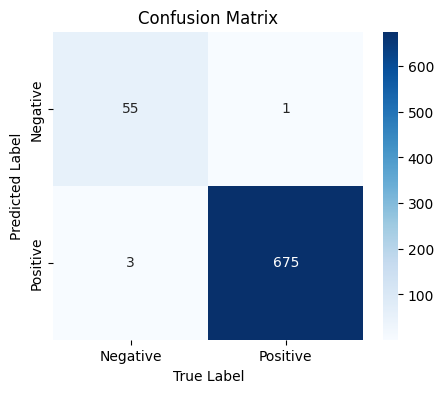


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       1.00      1.00      1.00       676

    accuracy                           0.99       734
   macro avg       0.99      0.97      0.98       734
weighted avg       0.99      0.99      0.99       734


Fold 4:


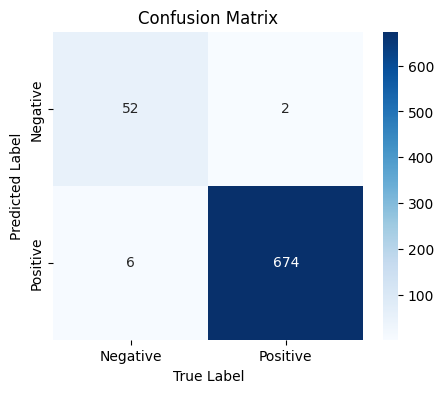


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        58
           1       0.99      1.00      0.99       676

    accuracy                           0.99       734
   macro avg       0.98      0.95      0.96       734
weighted avg       0.99      0.99      0.99       734


Fold 5:


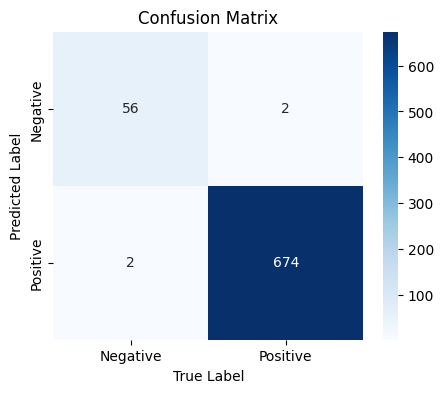


Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        58
           1       1.00      1.00      1.00       676

    accuracy                           0.99       734
   macro avg       0.98      0.98      0.98       734
weighted avg       0.99      0.99      0.99       734



In [ ]:
# Define hyperparameters
params = {"objective": "binary:logistic", "tree_method": "hist", "device" : "cuda" }

# Placeholder for model accuracy scores
accuracy_scores = []

# Placeholder for model metrics
conf_matrices = []
classification_reports = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create matrices
    dtrain = xgb.DMatrix(x_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(x_test, y_test, enable_categorical=True)

    #train the model
    model = xgb.train(
      params=params,
      dtrain=dtrain,
      num_boost_round=best_iterations[i-1]
    )
    # Make predictions
    y_test_pred =np.round(model.predict(dtest))

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred)
    conf_matrices.append(conf_matrix)
    classification_reports.append(classification_rep)

# Print average accuracy across all folds
Avg2=sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {Avg2:.2%}')

for i, (conf_matrix, classification_rep) in enumerate(zip(conf_matrices, classification_reports), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'\nFold {i} Classification Report:\n{classification_rep}')

## **XGBoost**

Fold 1 Accuracy: 99.59%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 99.46%
Fold 4 Accuracy: 98.64%
Fold 5 Accuracy: 99.46%

Average Accuracy: 99.43%

Average TPR: 1.00
Average TNR: 0.95
Average FPR: 0.05
Average G-Mean: 0.97

Fold 1:


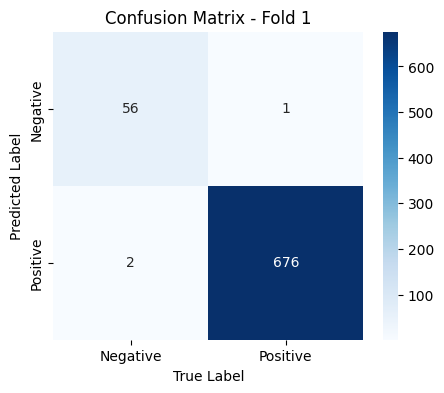

TPR: 1.00
TNR: 0.97
FPR: 0.03
G-Mean: 0.98

Fold 2:


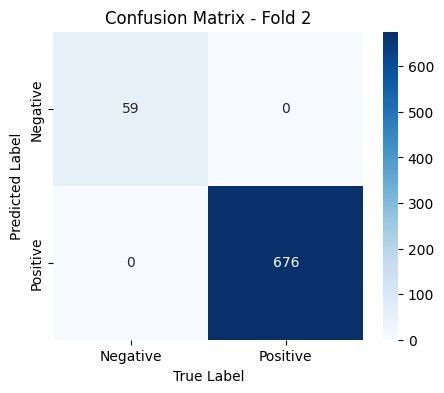

TPR: 1.00
TNR: 1.00
FPR: 0.00
G-Mean: 1.00

Fold 3:


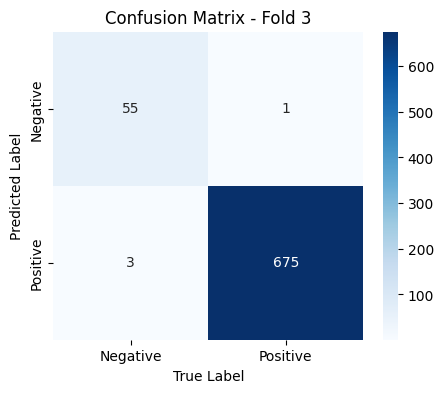

TPR: 1.00
TNR: 0.95
FPR: 0.05
G-Mean: 0.97

Fold 4:


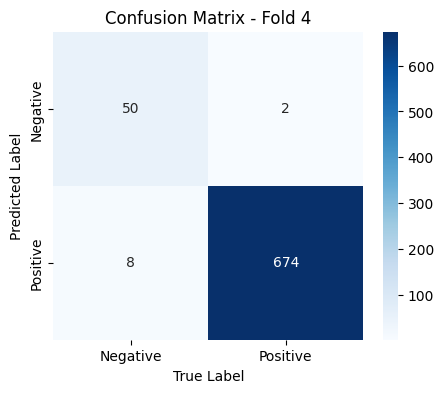

TPR: 1.00
TNR: 0.86
FPR: 0.14
G-Mean: 0.93

Fold 5:


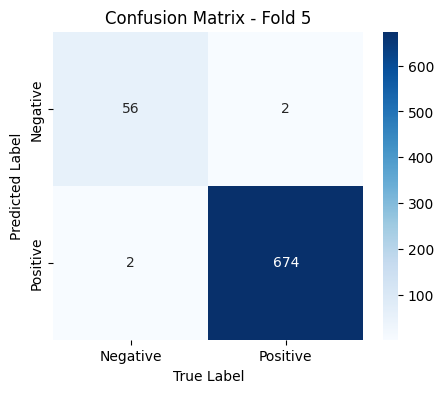

TPR: 1.00
TNR: 0.97
FPR: 0.03
G-Mean: 0.98


In [ ]:
XGB = XGBClassifier(n_estimators=5, random_state=42)
# Placeholder for cumulative metrics to compute averages
accuracy_scores = []
conf_matrices = []
fprs = []
tnrs = []
tprs = []
gmeans = []

# Use a for loop and StratifiedKFold's split operation to
# get the train and test row indexes for each split
for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
    # Use these indexes to split the data into train and test dataframes
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train the model
    XGB.fit(x_train, y_train)

    # Predict on the test set
    y_pred = XGB.predict(x_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Fold {i} Accuracy: {accuracy:.2%}')

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

    # Calculate FPR, TPR, TNR, and G-Mean from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    gmean = (tpr * tnr) ** 0.5  # G-Mean

    tprs.append(tpr)
    tnrs.append(tnr)
    fprs.append(fpr)
    gmeans.append(gmean)

# Calculate and print the average accuracy across all folds
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f'\nAverage Accuracy: {avg_accuracy:.2%}')

# Calculate and print average FPR, TNR, TPR, and G-Mean
avg_fpr = sum(fprs) / len(fprs)
avg_tnr = sum(tnrs) / len(tnrs)
avg_tpr = sum(tprs) / len(tprs)
avg_gmean = sum(gmeans) / len(gmeans)

print(f'\nAverage TPR: {avg_tpr:.2f}')
print(f'Average TNR: {avg_tnr:.2f}')
print(f'Average FPR: {avg_fpr:.2f}')
print(f'Average G-Mean: {avg_gmean:.2f}')

# Print detailed results per fold and show confusion matrices
for i, (conf_matrix,fpr, tnr, tpr, gmean) in enumerate(zip(conf_matrices, fprs, tnrs, tprs, gmeans), 1):
    print(f'\nFold {i}:')
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix.T, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title(f'Confusion Matrix - Fold {i}')
    plt.show()



    print(f'TPR: {tpr:.2f}')
    print(f'TNR: {tnr:.2f}')
    print(f'FPR: {fpr:.2f}')
    print(f'G-Mean: {gmean:.2f}')